# Hands-on

The hands-on consists of two parts The first one is to try to predict whether or not a customer of a bank will sign a contract. The second one is to train a convolutional neural network for face recognition.

In [1]:
%matplotlib inline
import os

# Numbers
import pandas as pd
import numpy as np

# Graphics
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from termcolor import (
    colored,
    cprint,
)

# Modeling
from sklearn.preprocessing import (
    MinMaxScaler,
    StandardScaler,
    OneHotEncoder,
    LabelBinarizer,
)
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
)

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight


import tensorflow as tf

from keras.layers import (
    Dense,
    Dropout,
    Flatten,
    Activation,
    BatchNormalization,
)
from keras.callbacks import EarlyStopping

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image


###### Voor Tensorflow-GPU ########
import re

#K.set_image_dim_ordering('tf')

# Make sure that we have pandas.DataFrames at each step in scikit-learn
from sklearn import set_config
set_config(transform_output="pandas")

# Multiprocessing options (joblib/loky)
os.environ['OMP_NUM_THREADS']='8'

# limit some output when printing pandas data
pd.set_option('display.max_rows',200)
pd.set_option('display.max_columns',200)
pd.set_option('mode.copy_on_write', True)
pd.set_option('future.no_silent_downcasting', True)

# Some defaults for matplotlib
plt.rcParams['image.cmap'] = 'gray'
# plt.tight_layout()
# plt.rcParams.update({
#     "axes.titlesize":"10",
#     "xtick.labelsize":"8",
#     "ytick.labelsize":"8",
#     "font.size": "8",
#     # "figure.figsize": [6,3],
# })

2025-03-10 15:13:32.933994: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-10 15:13:33.002979: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741616013.032165  959253 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741616013.040907  959253 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-10 15:13:33.106983: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
# Helpers
def display_title(title, h=1):
    match h:
        case 1:
            cprint(title, "blue", "on_light_grey")
        case 2:
            cprint(title, "black", "on_cyan")
        case 3:
            cprint(title, "black", "on_light_yellow")
        case _:
            cprint(title, "white", "on_light_magenta")

def display_title2(title, h=1):
    match h:
        case 1:
            print(colored(title, "blue"))
        case 2:
            print(colored(title, "red"))
        case 3:
            print(colored(title, "green"))
        case _:
            print(colored(title, "yellow"))



In [3]:
display_title("een")
display("aaaaaaa")
display_title("twee", h=2)
display("bbbb bbbbb bbb")
display_title("drie", h=3)
display("ccc ccc ccccc cc c cccc")
display_title("vier", h=4)
display("ddd dd ddddddd dddddddd dddd")


een


'aaaaaaa'

twee


'bbbb bbbbb bbb'

drie


'ccc ccc ccccc cc c cccc'

vier


'ddd dd ddddddd dddddddd dddd'

## Bank

A bank tries to predict whether a client will sign a certain insurance contract. The file 'bank.csv' contains data of thousands of clients.
The features include:
Input variables:

1 - age (numeric)

2 - job : type of job (categorical:admin.", "unknown", "unemployed", "management", "housemaid", "entrepreneur","student", "blue-collar","self-employed","retired","technician","services") 

3 - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)

4 - education (categorical: "unknown","secondary","primary","tertiary")

5 - default: has credit in default? (binary: "yes","no")

6 - balance: average yearly balance, in euros (numeric) 

7 - housing: has housing loan? (binary: "yes","no")

8 - loan: has personal loan? (binary: "yes","no")

9 - contact: contact communication type (categorical: "unknown","telephone","cellular") 

10 - day: last contact day of the month (numeric)

11 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")

12 - duration: last contact duration, in seconds (numeric)

13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)

15 - previous: number of contacts performed before this campaign and for this client (numeric)

16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")


The output variable = y. yes meaning the client signed the contract, no meaning the client didn't sign the contract.


Your task is to train a conventional feedforward neural network to predict the target y. Use a test set of 10000 samples. 

In [4]:
# Import customer satisfaction datataset

dataset = pd.read_csv('bank.csv',delimiter=';')
print(f"Dataset shape {dataset.shape}")
display(dataset.tail())


Dataset shape (45211, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no
45210,37,entrepreneur,married,secondary,no,2971,no,no,cellular,17,nov,361,2,188,11,other,no


In [5]:
# Statistical description of the dataset:
print(f"Dataset shape {dataset.shape}")
dataset.describe()

Dataset shape (45211, 17)


,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [6]:
# in practise the duration column is not available. That's why it needs to be removed from the dataset

# remove the 'duration' column

dataset.drop('duration',axis=1, inplace=True)
print(f"Dataset shape {dataset.shape}")

Dataset shape (45211, 16)


In [7]:
pd.set_option('future.no_silent_downcasting', True)
# replace yes/no by 1/0 
dataset['y'] = dataset['y'].replace({'no':0,'yes':1})
dataset['loan'] = dataset['loan'].replace({'no':0,'yes':1})
dataset['default'] = dataset['default'].replace({'no':0,'yes':1})
dataset['housing'] = dataset['housing'].replace({'no':0,'yes':1})

print(f"Dataset shape {dataset.shape}")
display(dataset)

Dataset shape (45211, 16)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,0,2143,1,0,unknown,5,may,1,-1,0,unknown,0
1,44,technician,single,secondary,0,29,1,0,unknown,5,may,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,0,2,1,1,unknown,5,may,1,-1,0,unknown,0
3,47,blue-collar,married,unknown,0,1506,1,0,unknown,5,may,1,-1,0,unknown,0
4,33,unknown,single,unknown,0,1,0,0,unknown,5,may,1,-1,0,unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,0,825,0,0,cellular,17,nov,3,-1,0,unknown,1
45207,71,retired,divorced,primary,0,1729,0,0,cellular,17,nov,2,-1,0,unknown,1
45208,72,retired,married,secondary,0,5715,0,0,cellular,17,nov,5,184,3,success,1
45209,57,blue-collar,married,secondary,0,668,0,0,telephone,17,nov,4,-1,0,unknown,0


In [8]:
# Apply one-hot encoding to the remaining categorical features. 

# Example: 
# one-hot encoding of job
dataset = pd.concat([dataset,pd.get_dummies(dataset['job'], prefix='job')],axis=1)
dataset.drop(['job'],axis=1, inplace=True)

# one-hot encoding of marital
dataset = pd.concat([dataset,pd.get_dummies(dataset['marital'], prefix='marital')],axis=1)
dataset.drop(['marital'],axis=1, inplace=True)

# one-hot encoding of education
dataset = pd.concat([dataset,pd.get_dummies(dataset['education'], prefix='education')],axis=1)
dataset.drop(['education'],axis=1, inplace=True)

# one-hot encoding of contact
dataset = pd.concat([dataset,pd.get_dummies(dataset['contact'], prefix='contact')],axis=1)
dataset.drop(['contact'],axis=1, inplace=True)

# one-hot encoding of month
dataset = pd.concat([dataset,pd.get_dummies(dataset['month'], prefix='month')],axis=1)
dataset.drop(['month'],axis=1, inplace=True)

# one-hot encoding of poutcome
dataset = pd.concat([dataset,pd.get_dummies(dataset['poutcome'], prefix='poutcome')],axis=1)
dataset.drop(['poutcome'],axis=1, inplace=True)

# Overview
print(f"Dataset shape {dataset.shape}")
display(dataset)

Dataset shape (45211, 48)


,age,default,balance,housing,loan,day,campaign,pdays,previous,y,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,contact_cellular,contact_telephone,contact_unknown,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,58,0,2143,1,0,5,1,-1,0,0,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True
1,44,0,29,1,0,5,1,-1,0,0,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True
2,33,0,2,1,1,5,1,-1,0,0,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True
3,47,0,1506,1,0,5,1,-1,0,0,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True
4,33,0,1,0,0,5,1,-1,0,0,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,0,825,0,0,17,3,-1,0,1,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True
45207,71,0,1729,0,0,17,2,-1,0,1,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True
45208,72,0,5715,0,0,17,5,184,3,1,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False
45209,57,0,668,0,0,17,4,-1,0,0,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True


In [9]:
# Split dataset into features and targets

y = dataset.y.values
X = dataset.drop('y',axis=1)

print(f"Features shape {X.shape}, type: {type(X)}")
print(f"Targets shape {y.shape}, type: {type(y)}")


Features shape (45211, 47), type: <class 'pandas.core.frame.DataFrame'>
Targets shape (45211,), type: <class 'numpy.ndarray'>


In [10]:
# Split into training set and test set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 10000, random_state =0)

# One-hot encoding of the targets
y_train_orig= y_train  # keep the original labels for testing purposes
y_train = to_categorical(y_train)


In [11]:
# Normalization of the features: Try Min-Max, standardscaler or robust scaler

# Standardscaler
#scaler = preprocessing.StandardScaler().fit(X_train)
#X_train = scaler.transform(X_train)
#X_test = scaler.transform(X_test)

# MinMax scaler

scaler = MinMaxScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


In [12]:
# Summary of sizes
display_title("Relative verdeling")
display(f"Feature set size: {X.shape}")
display(f"Target set size: {y.shape}")


Relative verdeling


'Feature set size: (45211, 47)'

'Target set size: (45211,)'

# Overzicht

```mermaid
flowchart LR

InputLayer[Uniform] -->|Text| B(Round)
B --> C{Decision}
C -->|One| D[Result 1]
C -->|Two| E[Result 2]
```

In [13]:
# Train a Neural network on the training data. Use 20 percent of the training data as validation data.

# Initialize the neural network

## parameters of the NN
model = Sequential()
dropoutrate = 0.2
batchsize = 128
inputdim = X_train.shape[1]  #30 input features
print(f"Number of input features: {inputdim}")
adam = tf.keras.optimizers.Adam() # Adam optimizer

model.add(Dense(40, input_dim=inputdim, kernel_initializer='uniform',activation='relu'))
model.add(Dropout(dropoutrate))
model.add(BatchNormalization())
model.add(Dense(40, kernel_initializer='uniform',activation='relu'))
model.add(Dropout(dropoutrate))
model.add(BatchNormalization())
model.add(Dense(10, kernel_initializer='uniform',activation='relu'))
model.add(Dropout(dropoutrate))
model.add(BatchNormalization())
model.add(Dense(2, activation='softmax'))

display(model.summary())


Number of input features: 47


I0000 00:00:1741616023.300073  959253 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3574 MB memory:  -> device: 0, name: NVIDIA RTX A3000 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
/home/sam/howest/howest-dl/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 40)             │         1,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 40)             │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 40)             │         1,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 40)             │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           410 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            22 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,352 (17.00 KB)

 Trainable params: 4,172 (16.30 KB)

 Non-trainable params: 180 (720.00 B)

None

In [14]:
# Activating the model with optimizer, loss function and metrics to monitor
model.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer=adam,
    metrics=['accuracy']
)

# Training
history = model.fit(
    X_train,
    y_train,
    epochs=50,
    validation_split=0.2,
    batch_size=batchsize,verbose=1
)


Epoch 1/50


I0000 00:00:1741616031.690213  959475 service.cc:148] XLA service 0x7fd8e4006be0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1741616031.690326  959475 service.cc:156]   StreamExecutor device (0): NVIDIA RTX A3000 Laptop GPU, Compute Capability 8.6
2025-03-10 15:13:51.742845: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1741616031.924414  959475 cuda_dnn.cc:529] Loaded cuDNN version 90300


 37/221 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5294 - loss: 0.8366

I0000 00:00:1741616033.613031  959475 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


221/221 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.6626 - loss: 0.6714 - val_accuracy: 0.8831 - val_loss: 0.3943
Epoch 2/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8763 - loss: 0.3749 - val_accuracy: 0.8830 - val_loss: 0.3285
Epoch 3/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8854 - loss: 0.3231 - val_accuracy: 0.8908 - val_loss: 0.3059
Epoch 4/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8883 - loss: 0.3118 - val_accuracy: 0.8915 - val_loss: 0.3038
Epoch 5/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8882 - loss: 0.3099 - val_accuracy: 0.8917 - val_loss: 0.3076
Epoch 6/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8894 - loss: 0.3103 - val_accuracy: 0.8919 - val_loss: 0.3037
Epoch 7/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8896 - loss: 0.3021 - val_accuracy: 0.8915 - val_loss: 0.3029
Epoch 8/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8898 - loss: 0.3017 - val_accuracy: 0.8915 - val

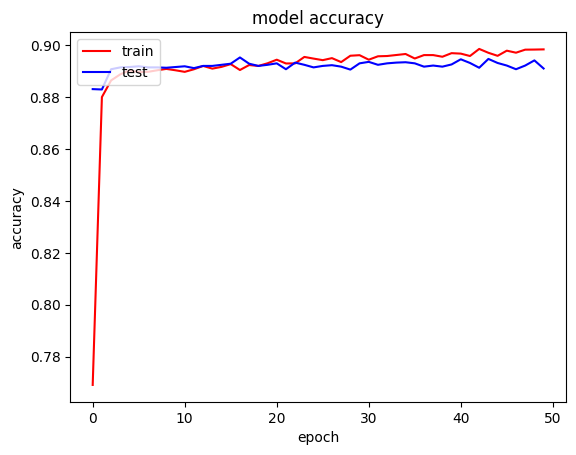

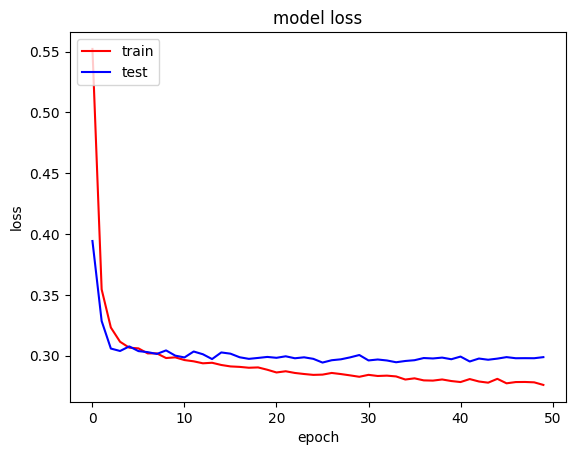

In [16]:
# Plot of the training history

# Accuray 
plt.plot(history.history['accuracy'],'r')
plt.plot(history.history['val_accuracy'],'b')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# Loss 
plt.plot(history.history['loss'],'r')
plt.plot(history.history['val_loss'],'b')

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [17]:
# Testing with the test set

y_pred = model.predict_classes(X_test)
print('\n')
print(classification_report(y_test, y_pred))

cf = confusion_matrix(y_test, y_pred)

print(cf)
print(accuracy_score(y_test, y_pred) * 100) 

# ROC
probs = model.predict_proba(X_test)
# calculate the fpr and tpr for all thresholds of the classification

preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# plot
#import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


AttributeError: 'Sequential' object has no attribute 'predict_classes'

## Classweight balancing

As the data is unbalanced, the neural netwerk tends to have a preference for the majority class. 
One of the approaches is to use classweight balancing. This means that during the training phase, a misclassification of a sample from the minority class results in a higher loss.

In [13]:
# Histogram of the classcount
label_count = np.bincount(y)

print('count klasse 0: ',label_count[0])
print('count klasse 1: ',label_count[1])

print('ratio: ',label_count[0]/label_count[1])


sns.catplot(x='y',kind='count', data=dataset)

TypeError: Cannot cast array data from dtype('O') to dtype('int64') according to the rule 'safe'

In [14]:
# Train a Neural network on the training data. Use 20 percent of the training data as validation data.

# Initialize the neural network

## parameters of the NN
model = Sequential()
dropoutrate = 0.2
batchsize = 64
epochs = 10
inputdim = X_train.shape[1]  #30 input features
adam = tf.keras.optimizers.Adam() # Adam optimizer


model.add(Dense(50, input_dim=inputdim, kernel_initializer='uniform',activation='relu'))
model.add(Dropout(dropoutrate))
model.add(BatchNormalization())
model.add(Dense(50, kernel_initializer='uniform',activation='relu'))
model.add(Dropout(dropoutrate))
model.add(BatchNormalization())
model.add(Dense(50, kernel_initializer='uniform',activation='relu'))
model.add(Dropout(dropoutrate))
model.add(BatchNormalization())
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])

class_weights = class_weight.compute_class_weight('balanced',np.unique(y_train_orig),y_train_orig)
print(class_weights)
class_weights= dict(enumerate(class_weights))


history = model.fit(X_train, y_train, validation_split=0.2, epochs=epochs, verbose=1,class_weight=class_weights)


/home/sam/howest/howest-dl/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


TypeError: too many positional arguments

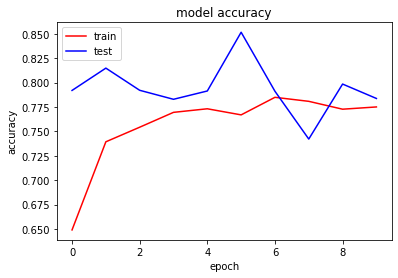

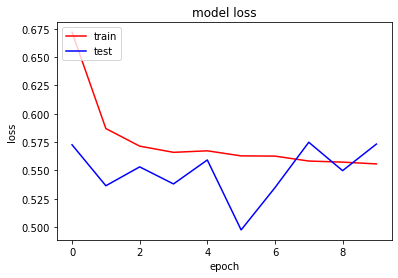

In [16]:
# Plot history

# Accuray 
plt.plot(history.history['accuracy'],'r')
plt.plot(history.history['val_accuracy'],'b')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# Loss 
plt.plot(history.history['loss'],'r')
plt.plot(history.history['val_loss'],'b')

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



              precision    recall  f1-score   support

           0       0.94      0.81      0.87      8824
           1       0.31      0.62      0.41      1176

    accuracy                           0.79     10000
   macro avg       0.62      0.72      0.64     10000
weighted avg       0.87      0.79      0.82     10000

[[7191 1633]
 [ 450  726]]
79.17


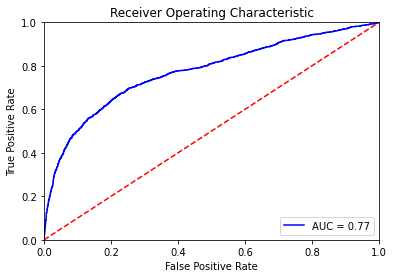

In [17]:
# Testing

y_pred = model.predict_classes(X_test)
print('\n')
print(classification_report(y_test, y_pred))

cf = confusion_matrix(y_test, y_pred)

print(cf)
print(accuracy_score(y_test, y_pred) * 100) 

# ROC
probs = model.predict_proba(X_test)
# calculate the fpr and tpr for all thresholds of the classification

preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# plot
#import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


## Oversampling 

Another way of dealing with unbalanced data is to oversample the data. This means that the data will be balanced by creating additional samples from the minority class until equilibrium.

In [15]:
# Oversampling with SMOTE

from imblearn.over_sampling import BorderlineSMOTE
X_resampled, y_resampled = BorderlineSMOTE().fit_resample(X_train, y_train_orig)

y_resampled_orig = y_resampled
y_resampled = to_categorical(y_resampled)




ModuleNotFoundError: No module named 'imblearn'

In [19]:
# Train a Neural network on the training data. Use 20 percent of the training data as validation data.

# Initialize the neural network

## parameters of the NN
model = Sequential()
dropoutrate = 0.2
batchsize = 64
inputdim = X_train.shape[1]  #30 input features
adam = tf.keras.optimizers.Adam() # Adam optimizer
#sgd = tf.keras.optimizers.sgd(lr=0.001)


model.add(Dense(40, input_dim=inputdim, kernel_initializer='uniform',activation='relu'))
model.add(Dropout(dropoutrate))
model.add(BatchNormalization())
model.add(Dense(40, kernel_initializer='uniform',activation='relu'))
model.add(Dropout(dropoutrate))
model.add(BatchNormalization())
model.add(Dense(10, kernel_initializer='uniform',activation='relu'))
model.add(Dropout(dropoutrate))
model.add(BatchNormalization())
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])

# Training

history = model.fit(X_resampled, y_resampled, epochs=50,validation_split=0.2, batch_size=batchsize,verbose=1)

Epoch 1/50
778/778 [==============================] - 1s 2ms/step - loss: 0.5518 - accuracy: 0.7308 - val_loss: 0.6974 - val_accuracy: 0.6281
Epoch 2/50
778/778 [==============================] - 1s 1ms/step - loss: 0.5064 - accuracy: 0.7664 - val_loss: 0.6920 - val_accuracy: 0.6359
Epoch 3/50
778/778 [==============================] - 1s 1ms/step - loss: 0.4917 - accuracy: 0.7743 - val_loss: 0.6238 - val_accuracy: 0.6518
Epoch 4/50
778/778 [==============================] - 1s 1ms/step - loss: 0.4843 - accuracy: 0.7793 - val_loss: 0.6360 - val_accuracy: 0.6857
Epoch 5/50
778/778 [==============================] - 1s 1ms/step - loss: 0.4771 - accuracy: 0.7823 - val_loss: 0.6199 - val_accuracy: 0.6671
Epoch 6/50
778/778 [==============================] - 1s 1ms/step - loss: 0.4737 - accuracy: 0.7843 - val_loss: 0.5857 - val_accuracy: 0.6793
Epoch 7/50
778/778 [==============================] - 1s 1ms/step - loss: 0.4697 - accuracy: 0.7872 - val_loss: 0.6029 - val_accuracy: 0.6764
Epoch 

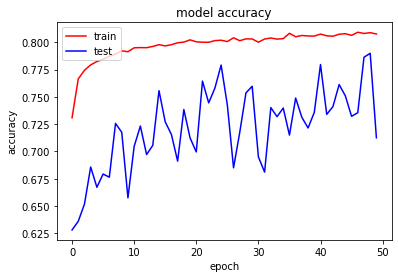

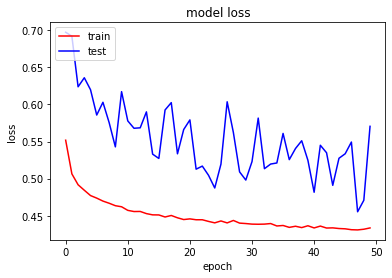

In [20]:
# Plot history

# Accuray 
plt.plot(history.history['accuracy'],'r')
plt.plot(history.history['val_accuracy'],'b')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# Loss 
plt.plot(history.history['loss'],'r')
plt.plot(history.history['val_loss'],'b')

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



              precision    recall  f1-score   support

           0       0.93      0.89      0.91      8824
           1       0.38      0.50      0.43      1176

    accuracy                           0.84     10000
   macro avg       0.65      0.69      0.67     10000
weighted avg       0.87      0.84      0.85     10000

[[7861  963]
 [ 590  586]]
84.47


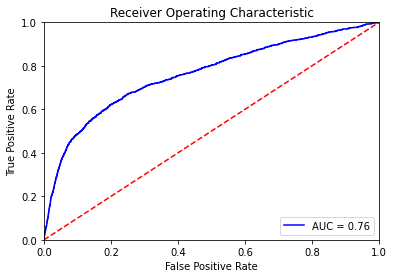

In [22]:
# Testing

y_pred = model.predict_classes(X_test)
print('\n')
print(classification_report(y_test, y_pred))

cf = confusion_matrix(y_test, y_pred)

print(cf)
print(accuracy_score(y_test, y_pred) * 100) 

# ROC
probs = model.predict_proba(X_test)
# calculate the fpr and tpr for all thresholds of the classification

preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# plot
#import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
